# Likelihood surface

Tony Wong (<anthony.e.wong@colorado.edu>)

## Read in the data, and uncertainties

Some preliminaries.

In [7]:
library(repr)
library(sn)
library(hexbin)
library(gplots)

Actually read in the data. Using the CO2 uncertainty cutoff of 20 ppmv (minimum), so use that here too.

In [80]:
#dist <- 'ga'
dist <- 'ln'
#dist <- 'sn'

co2_uncertainty_cutoff <- 20

if(dist=='ga') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_GAMMA-co2_31Jul2018.csv'}
if(dist=='ln') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_LN-co2_31Jul2018.csv'}
if(dist=='sn') {filename.data <- '../input_data/CO2_Proxy_Foster2017_calib_SN-co2_06Jun2017.csv'}
source('GEOCARB-2014_getData.R')

# Which proxy sets to assimilate? (set what you want to "TRUE", others to "FALSE")
data_to_assim <- cbind( c("paleosols" , TRUE),
                        c("alkenones" , TRUE),
                        c("stomata"   , TRUE),
                        c("boron"     , TRUE),
                        c("liverworts", TRUE) )

ind_data    <- which(data_to_assim[2,]==TRUE)
n_data_sets <- length(ind_data)
ind_assim   <- vector("list",n_data_sets)
for (i in 1:n_data_sets) {
  ind_assim[[i]] <- which(as.character(data_calib_all$proxy_type) == data_to_assim[1,ind_data[i]])
}

data_calib <- data_calib_all[unlist(ind_assim),]

# filtering out of some data points with too-narrow uncertainties in
# co2 (causing overconfidence in model simulations that match those data points
# well). set to +65%, - 30% uncertain range around the central estimate
if(co2_uncertainty_cutoff > 0) {
  co2_halfwidth <- 0.5*(data_calib$co2_high - data_calib$co2_low)
  ind_filter <- which(co2_halfwidth < co2_uncertainty_cutoff)
  ind_remove <- NULL
  for (ii in ind_filter) {
    range_original <- data_calib[ii,'co2_high']-data_calib[ii,'co2_low']
    range_updated  <- data_calib[ii,'co2']*0.95
    if (range_updated > range_original) {
      # update to the wider uncertain range if +65/-30% is wider
      data_calib[ii,'co2_high'] <- data_calib[ii,'co2']*1.65
      data_calib[ii,'co2_low']  <- data_calib[ii,'co2']*0.70
    } else {
      # otherwise, remove
      ind_remove <- c(ind_remove, ii)
    }
  }
  data_calib <- data_calib[-ind_filter,]    # removing all of the possibly troublesome points
  ##data_calib <- data_calib[-ind_remove,]    # remove only those the revised range does not help
}

## Sampling from the likelihood function

In [81]:
n_sample_per_point <- 5000
samples <- array(NA, c(nrow(data_calib)*n_sample_per_point, 2))

for (t in 1:nrow(data_calib)) {
    idx <- ((t-1)*n_sample_per_point+1):(t*n_sample_per_point)
    samples[idx,1] <- rep(data_calib$age[t], n_sample_per_point)
    if (dist=='ga') {
        samples[idx,2] <- rgamma(shape=data_calib$shape_co2[t], scale=data_calib$scale_co2[t],
                                 n=n_sample_per_point)
    } else if (dist=='ln') {
        samples[idx,2] <- rlnorm(meanlog=data_calib$meanlog_co2[t], sdlog=data_calib$sdlog_co2[t],
                                 n=n_sample_per_point)
    } else if (dist=='sn') {
        samples[idx,2] <- rsn(xi=data_calib$xi_co2[t], omega=data_calib$omega_co2[t],
                              alpha=data_calib$alpha_co2[t], n=n_sample_per_point)
    }
}

dfSamples <- data.frame(samples)

## Plotting

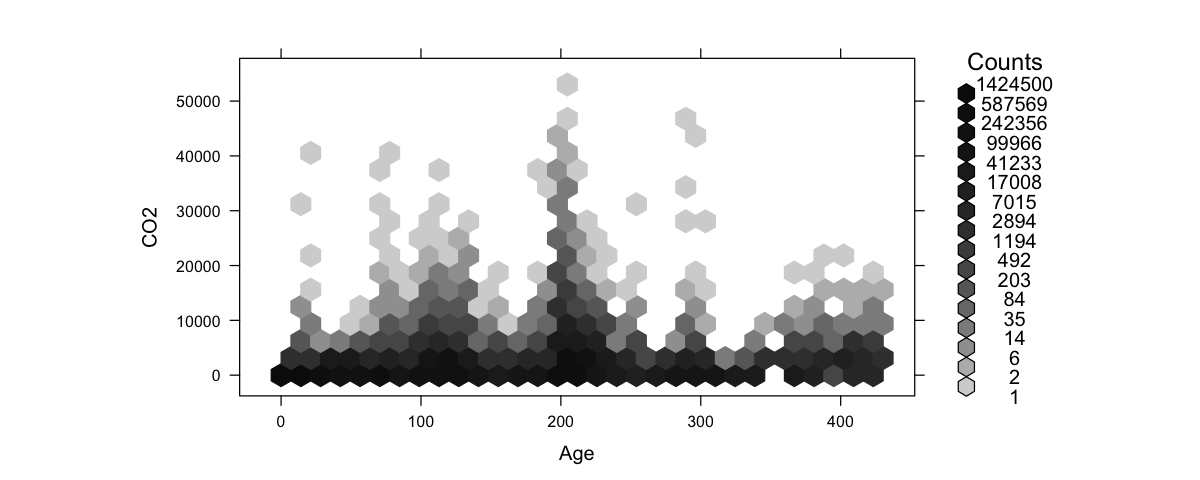

In [82]:
options(repr.plot.width=10, repr.plot.height=4)
hexbinplot(dfSamples[,2]~dfSamples[,1], dfSamples, trans=log, inv=exp, asp=.5, xlab='Age', ylab='CO2')

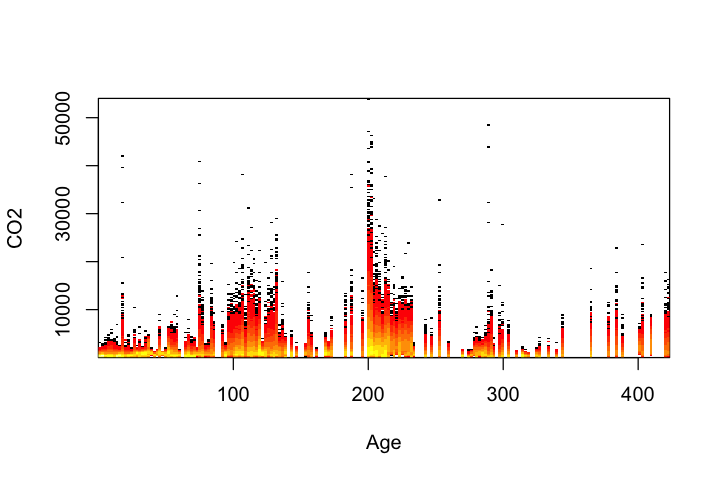

In [83]:
options(repr.plot.width=6, repr.plot.height=4)
h2 <- hist2d(dfSamples, FUN=function(x) log(length(x)), xlab='Age', ylab='CO2')
lines(c(0,500),c(0,0))

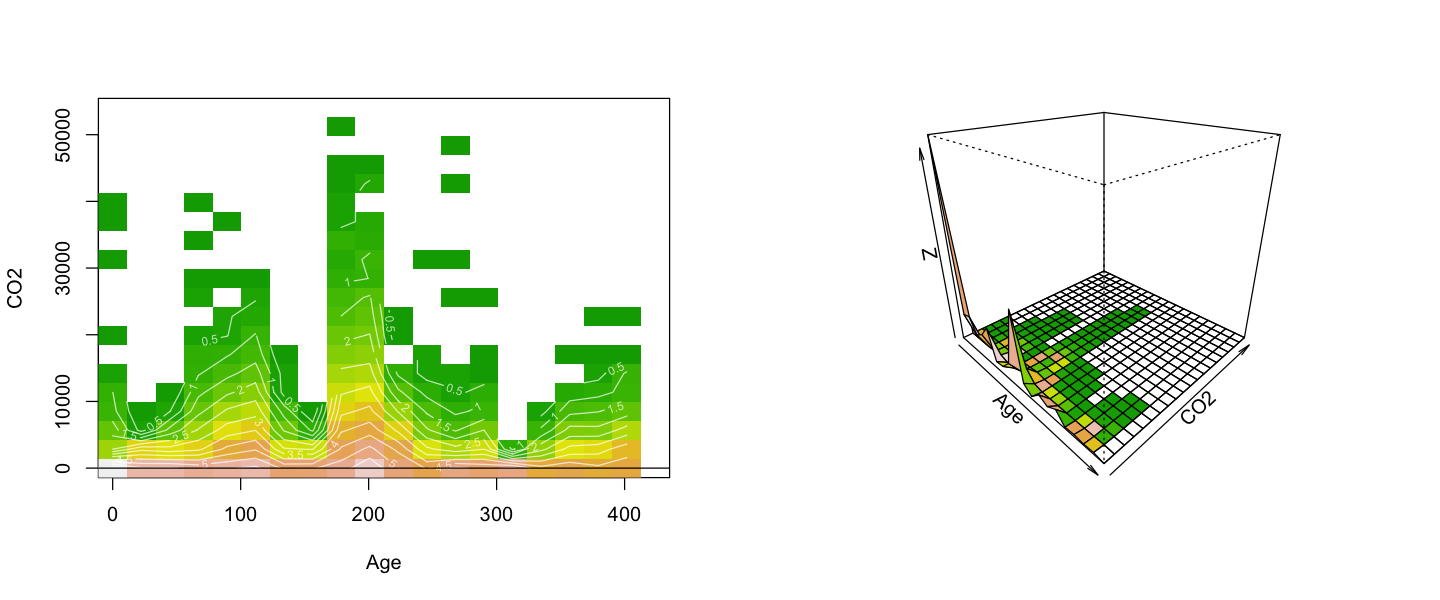

In [84]:
xy <- samples

nbins <- 20

x.bin <- seq(floor(min(xy[,1])), ceiling(max(xy[,1])), length=nbins)
y.bin <- seq(floor(min(xy[,2])), ceiling(max(xy[,2])), length=nbins)

freq <-  as.data.frame(table(findInterval(xy[,1], x.bin),findInterval(xy[,2], y.bin)))
freq[,1] <- as.numeric(freq[,1])
freq[,2] <- as.numeric(freq[,2])

freq2D <- diag(nbins)*0
freq2D[cbind(freq[,1], freq[,2])] <- freq[,3]

options(repr.plot.width=12, repr.plot.height=5)

par(mfrow=c(1,2))
image(x.bin, y.bin, log10(freq2D), col=terrain.colors(1024), xlab='Age', ylab='CO2')
contour(x.bin, y.bin, log10(freq2D), add=TRUE, col=rgb(1,1,1,.7))
lines(c(-100,500),c(0,0))

palette(terrain.colors(1024))
cols <- (freq2D[-1,-1] + freq2D[-1,-(nbins-1)] + freq2D[-(nbins-1),-(nbins-1)] + freq2D[-(nbins-1),-1])/4
persp(freq2D, col=cols, xlab='Age', ylab='CO2', phi=25, theta=45)